# Hackathon: Inventory Demand Forecasting

## Objective
Develop a machine learning model to forecast product demand over manufacturing lead times for optimal inventory management.

## Approach
- **Model Architecture**: Hurdle Model (two-stage) with tier-specific training
  - Stage 1: Binary classifier (will there be demand?)
  - Stage 2: Quantile regression (median and upper bound predictions)
- **Product Segmentation**: Products grouped by historical sales volume
- **Feature Engineering**: Enhanced with EMA trends, seasonality, and lag features
- **Evaluation**: Focus on calibration and business metrics (WAPE, stockout prevention)

## 1. Setup and Imports

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime
from pathlib import Path

# Machine learning libraries
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score

# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Libraries imported successfully!
NumPy version: 2.3.5
Pandas version: 2.3.3
LightGBM version: 4.6.0


In [2]:
# Define file paths
DATA_DIR = Path('Data')
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

# Input: Raw sales data
RAW_DATA_FILE = DATA_DIR / 'raw' / 'Unterlagen Teilnehmer' / 'auftraege_mit_sku_Teilnehmer.xlsx'

# Output: Trained model and metadata
MODEL_OUTPUT = MODEL_DIR / 'lightgbm_final.pkl'
METADATA_OUTPUT = MODEL_DIR / 'model_metadata.json'

print(f"Input file: {RAW_DATA_FILE}")
print(f"Model output: {MODEL_OUTPUT}")

Input file: Data/raw/Unterlagen Teilnehmer/auftraege_mit_sku_Teilnehmer.xlsx
Model output: models/lightgbm_final.pkl


## 2. Data Loading and Cleaning

Load raw sales transaction data and perform initial preprocessing.

In [3]:
# Load raw sales data
print("Loading raw sales data...")
df_sales = pd.read_excel(RAW_DATA_FILE, sheet_name='Auftragsdaten')

# Remove location column (not needed for forecasting)
df_sales = df_sales.drop(columns=['Ort'], errors='ignore')

# Convert date column to datetime
df_sales['Auftragsdatum'] = pd.to_datetime(df_sales['Auftragsdatum'])

# Preprocess SKU column (critical for matching with manufacturing time data)
# Step 1: Remove dots from SKUs that contain them
mask = df_sales['SKU'].str.contains('.', regex=False, na=False)
df_sales.loc[mask, 'SKU'] = df_sales.loc[mask, 'SKU'].str.replace('.', '', regex=False)

# Step 2: Convert all SKUs to lowercase
df_sales['SKU'] = df_sales['SKU'].str.lower()

print(f"Loaded {len(df_sales):,} transactions")
print(f"Date range: {df_sales['Auftragsdatum'].min()} to {df_sales['Auftragsdatum'].max()}")
print(f"Unique products: {df_sales['SKU'].nunique()}")

# df_sales.head()

Loading raw sales data...
Loaded 6,357 transactions
Date range: 2024-01-26 08:44:40 to 2025-11-24 07:40:07
Unique products: 224


In [4]:
# Load manufacturing time data from product details Excel
print("Loading manufacturing time data from product details...")

# Load Produktsparte 1 data
df_product_1 = pd.read_excel(
    'Data/raw/Unterlagen Teilnehmer/Produktionszeit_Warenfluss_Hackathon_Teilnehmer.xlsx',
    sheet_name='Produktsparte 1_Produktionszeit',
    header=1
)

# Load Produktsparte 2 data
df_product_2 = pd.read_excel(
    'Data/raw/Unterlagen Teilnehmer/Produktionszeit_Warenfluss_Hackathon_Teilnehmer.xlsx',
    sheet_name='Produktsparte 2_Produktionzeit',
    header=1
)

# Load Produktsparte 3 data
df_product_3 = pd.read_excel(
    'Data/raw/Unterlagen Teilnehmer/Produktionszeit_Warenfluss_Hackathon_Teilnehmer.xlsx',
    sheet_name='Produktsparte 3_Produktionszeit',
    header=1
)

# Calculate manufacturing_time for each product sheet
# Sum all production time columns to get total manufacturing time
time_columns = [
    'Produzent 1', 'Produzent 2', 'Produzent 3', 'Produzent 4',
    'Duplexbeschichter', 'Verzinken (=Produzent 2)',
    'Annahme Lagerbestand Status Quo' # ,'Lager'
]

df_product_1['manufacturing_time'] = df_product_1[time_columns].fillna(0).sum(axis=1)
df_product_2['manufacturing_time'] = df_product_2[time_columns].fillna(0).sum(axis=1)
df_product_3['manufacturing_time'] = df_product_3[time_columns].fillna(0).sum(axis=1)

# Add product type labels
df_product_1['product_type'] = 'product_1'
df_product_2['product_type'] = 'product_2'
df_product_3['product_type'] = 'product_3'

# Combine all manufacturing time data
df_manufacturing_time = pd.concat([
    df_product_1[['SKU', 'manufacturing_time', 'product_type']],
    df_product_2[['SKU', 'manufacturing_time', 'product_type']],
    df_product_3[['SKU', 'manufacturing_time', 'product_type']]
], ignore_index=True)

# Normalize SKU to lowercase for matching
df_manufacturing_time['SKU'] = df_manufacturing_time['SKU'].str.lower()

print(f"Loaded manufacturing times for {df_manufacturing_time['SKU'].nunique()} unique SKUs")
print(f"Manufacturing time range: {df_manufacturing_time['manufacturing_time'].min():.0f} - {df_manufacturing_time['manufacturing_time'].max():.0f} days")

# Merge with sales data
df_sales = df_sales.merge(
    df_manufacturing_time,
    on='SKU',
    how='left'
)

# Check for unmatched SKUs
unmatched_count = df_sales['manufacturing_time'].isna().sum()
if unmatched_count > 0:
    unmatched_skus = df_sales[df_sales['manufacturing_time'].isna()]['SKU'].unique()
    print(f"\nWarning: {unmatched_count} records ({len(unmatched_skus)} unique SKUs) without manufacturing time")
    print("Removing unmatched SKUs from dataset...")
    df_sales = df_sales[df_sales['manufacturing_time'].notna()]

print(f"\nFinal dataset: {len(df_sales):,} transactions")
print(f"Unique products with manufacturing time: {df_sales['SKU'].nunique()}")
print("\nManufacturing time distribution:")
print(df_sales.groupby('product_type')['manufacturing_time'].agg(['min', 'max', 'mean']).round(1))

Loading manufacturing time data from product details...
Loaded manufacturing times for 200 unique SKUs
Manufacturing time range: 10 - 75 days

Removing unmatched SKUs from dataset...

Final dataset: 4,405 transactions
Unique products with manufacturing time: 141

Manufacturing time distribution:
               min   max  mean
product_type                  
product_1     10.0  75.0  34.7
product_2     10.0  75.0  32.0
product_3     15.0  30.0  26.0


## 3. Data Aggregation and Time Series Creation

Convert transaction-level data to daily time series with complete date skeleton for each SKU.

In [5]:
# Calculate price per unit for each transaction
df_sales['price_per_unit'] = df_sales['Gesamtpreis €'] / df_sales['Auftragspositionen/Menge']

# Normalize dates to daily level (remove time component)
df_sales['date'] = df_sales['Auftragsdatum'].dt.normalize()

# Aggregate multiple transactions on the same day for same SKU
print("Aggregating to daily time series per SKU...")
df_daily = df_sales.groupby(['SKU', 'date', 'manufacturing_time', 'product_type']).agg({
    'Auftragspositionen/Menge': 'sum',
    'price_per_unit': 'mean',
    'Gesamtpreis €': 'sum'
}).reset_index()

df_daily.columns = ['SKU', 'date', 'manufacturing_time', 'product_type', 
                    'quantity', 'price_per_unit', 'total_price']

print(f"Daily aggregated data: {len(df_daily):,} records")
# df_daily.head()

Aggregating to daily time series per SKU...
Daily aggregated data: 3,705 records


In [6]:
# Create complete date skeleton
# This ensures every SKU has an entry for every day (with 0 sales on days without transactions)
print("Creating complete date skeleton for all SKUs...")

min_date = df_daily['date'].min()
max_date = df_daily['date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Get unique SKU metadata
sku_metadata = df_daily[['SKU', 'manufacturing_time', 'product_type']].drop_duplicates()

# Create skeleton: all combinations of SKU x Date
skeleton_data = []
for _, row in sku_metadata.iterrows():
    for date in all_dates:
        skeleton_data.append({
            'SKU': row['SKU'],
            'date': date,
            'manufacturing_time': row['manufacturing_time'],
            'product_type': row['product_type']
        })

df_skeleton = pd.DataFrame(skeleton_data)

# Merge skeleton with actual sales data
df_complete = df_skeleton.merge(
    df_daily[['SKU', 'date', 'quantity', 'price_per_unit']], 
    on=['SKU', 'date'], 
    how='left'
)

# Fill missing quantities with 0 (no sales on that day)
df_complete['quantity'] = df_complete['quantity'].fillna(0)

# Fill missing prices with SKU average price
sku_avg_price = df_daily.groupby('SKU')['price_per_unit'].mean()
df_complete['price_per_unit'] = df_complete.apply(
    lambda row: row['price_per_unit'] if pd.notna(row['price_per_unit']) 
                else sku_avg_price.get(row['SKU'], 0),
    axis=1
)

print(f"Complete time series: {len(df_complete):,} rows")
print(f"({df_complete['SKU'].nunique()} SKUs × {len(all_dates)} days)")

Creating complete date skeleton for all SKUs...
Complete time series: 93,624 rows
(141 SKUs × 664 days)
Complete time series: 93,624 rows
(141 SKUs × 664 days)


## 4. Target Variable Creation

The target variable represents the cumulative demand during the manufacturing lead time.

**Business Logic**: 
- If we place an order today, it will arrive after `manufacturing_time` days
- We need to predict total demand during this lead time period
- Target = sum of sales from day t+1 to day t+manufacturing_time

In [7]:
def calculate_target_lead_time_demand(group):
    """
    Calculate target variable for each observation.
    
    For a product with 30-day manufacturing time on June 1:
    - Target = sum of sales from June 2 to July 1 (30 days)
    - This represents demand while the order is being manufactured
    """
    group = group.sort_values('date').reset_index(drop=True)
    manufacturing_time = int(group['manufacturing_time'].iloc[0])
    
    # Calculate cumulative demand over lead time window
    # shift(-1) starts from next day, rolling sum over manufacturing_time days
    group['target_lead_time_demand'] = group['quantity'].shift(-1).rolling(
        window=manufacturing_time, 
        min_periods=manufacturing_time
    ).sum()
    
    # Binary target for hurdle model: will there be any demand?
    group['target_binary'] = (group['target_lead_time_demand'] > 0).astype(int)
    
    return group

print("Calculating target variables...")
df_complete = df_complete.groupby('SKU', group_keys=False).apply(
    calculate_target_lead_time_demand
)

# Remove rows where target cannot be calculated (end of time series)
df_valid = df_complete[df_complete['target_lead_time_demand'].notna()].copy()

print(f"Valid observations: {len(df_valid):,}")
print(f"Target statistics:")
print(f"  - Mean demand: {df_valid['target_lead_time_demand'].mean():.2f} units")
print(f"  - Median demand: {df_valid['target_lead_time_demand'].median():.2f} units")
print(f"  - Zero demand rate: {(df_valid['target_lead_time_demand'] == 0).mean()*100:.1f}%")
print(f"  - Positive class (binary): {df_valid['target_binary'].mean()*100:.1f}%")

Calculating target variables...
Valid observations: 88,779
Target statistics:
  - Mean demand: 2.76 units
  - Median demand: 0.00 units
  - Zero demand rate: 53.8%
  - Positive class (binary): 46.2%
Valid observations: 88,779
Target statistics:
  - Mean demand: 2.76 units
  - Median demand: 0.00 units
  - Zero demand rate: 53.8%
  - Positive class (binary): 46.2%


## 5. Product Tiering

Segment products by historical sales volume to apply tier-specific modeling strategies.

**Tiers**:
- Tier 1: High volume (≥100 sales records) - Use ML with complex models
- Tier 2: Medium-high volume (50-99 records) - Use ML with complex models  
- Tier 3: Medium volume (20-49 records) - Use ML with regularization
- Tier 4: Low volume (10-19 records) - Use ML with regularization
- Tier 5: Very low volume (<10 records) - Use simple baseline (moving average)

In [8]:
# Count number of sales records per SKU
sku_sales_count = df_valid[df_valid['quantity'] > 0].groupby('SKU').size().reset_index(name='sales_records')

def assign_tier(sales_count):
    """Assign tier based on historical sales volume"""
    if sales_count >= 100:
        return 1
    elif sales_count >= 50:
        return 2
    elif sales_count >= 20:
        return 3
    elif sales_count >= 10:
        return 4
    else:
        return 5

sku_sales_count['tier'] = sku_sales_count['sales_records'].apply(assign_tier)

# Merge tiers back to main dataset
df_valid = df_valid.merge(sku_sales_count[['SKU', 'tier']], on='SKU', how='left')
df_valid['tier'] = df_valid['tier'].fillna(5).astype(int)

# Also create lead time categories for potential segmentation
def assign_lead_time_category(mfg_time):
    """Categorize manufacturing time into short/medium/long"""
    if mfg_time <= 25:
        return 'short'
    elif mfg_time <= 50:
        return 'medium'
    else:
        return 'long'

df_valid['lead_time_category'] = df_valid['manufacturing_time'].apply(assign_lead_time_category)

# Display tier distribution
print("Product Tier Distribution:")
tier_summary = df_valid.groupby('tier').agg({
    'SKU': 'nunique',
    'target_lead_time_demand': ['mean', 'median']
}).round(2)
tier_summary.columns = ['SKU_count', 'Avg_demand', 'Median_demand']
print(tier_summary)

Product Tier Distribution:
      SKU_count  Avg_demand  Median_demand
tier                                      
1             8       15.24            9.0
2            10        7.65            5.0
3            35        3.76            2.0
4            19        1.70            1.0
5            69        0.38            0.0


## 5.1 Exploratory Data Analysis (EDA)

Visualizing key patterns in the data:
- Sales trends over time
- Manufacturing lead time distribution
- Tier distribution
- Seasonality

Generating EDA plots...


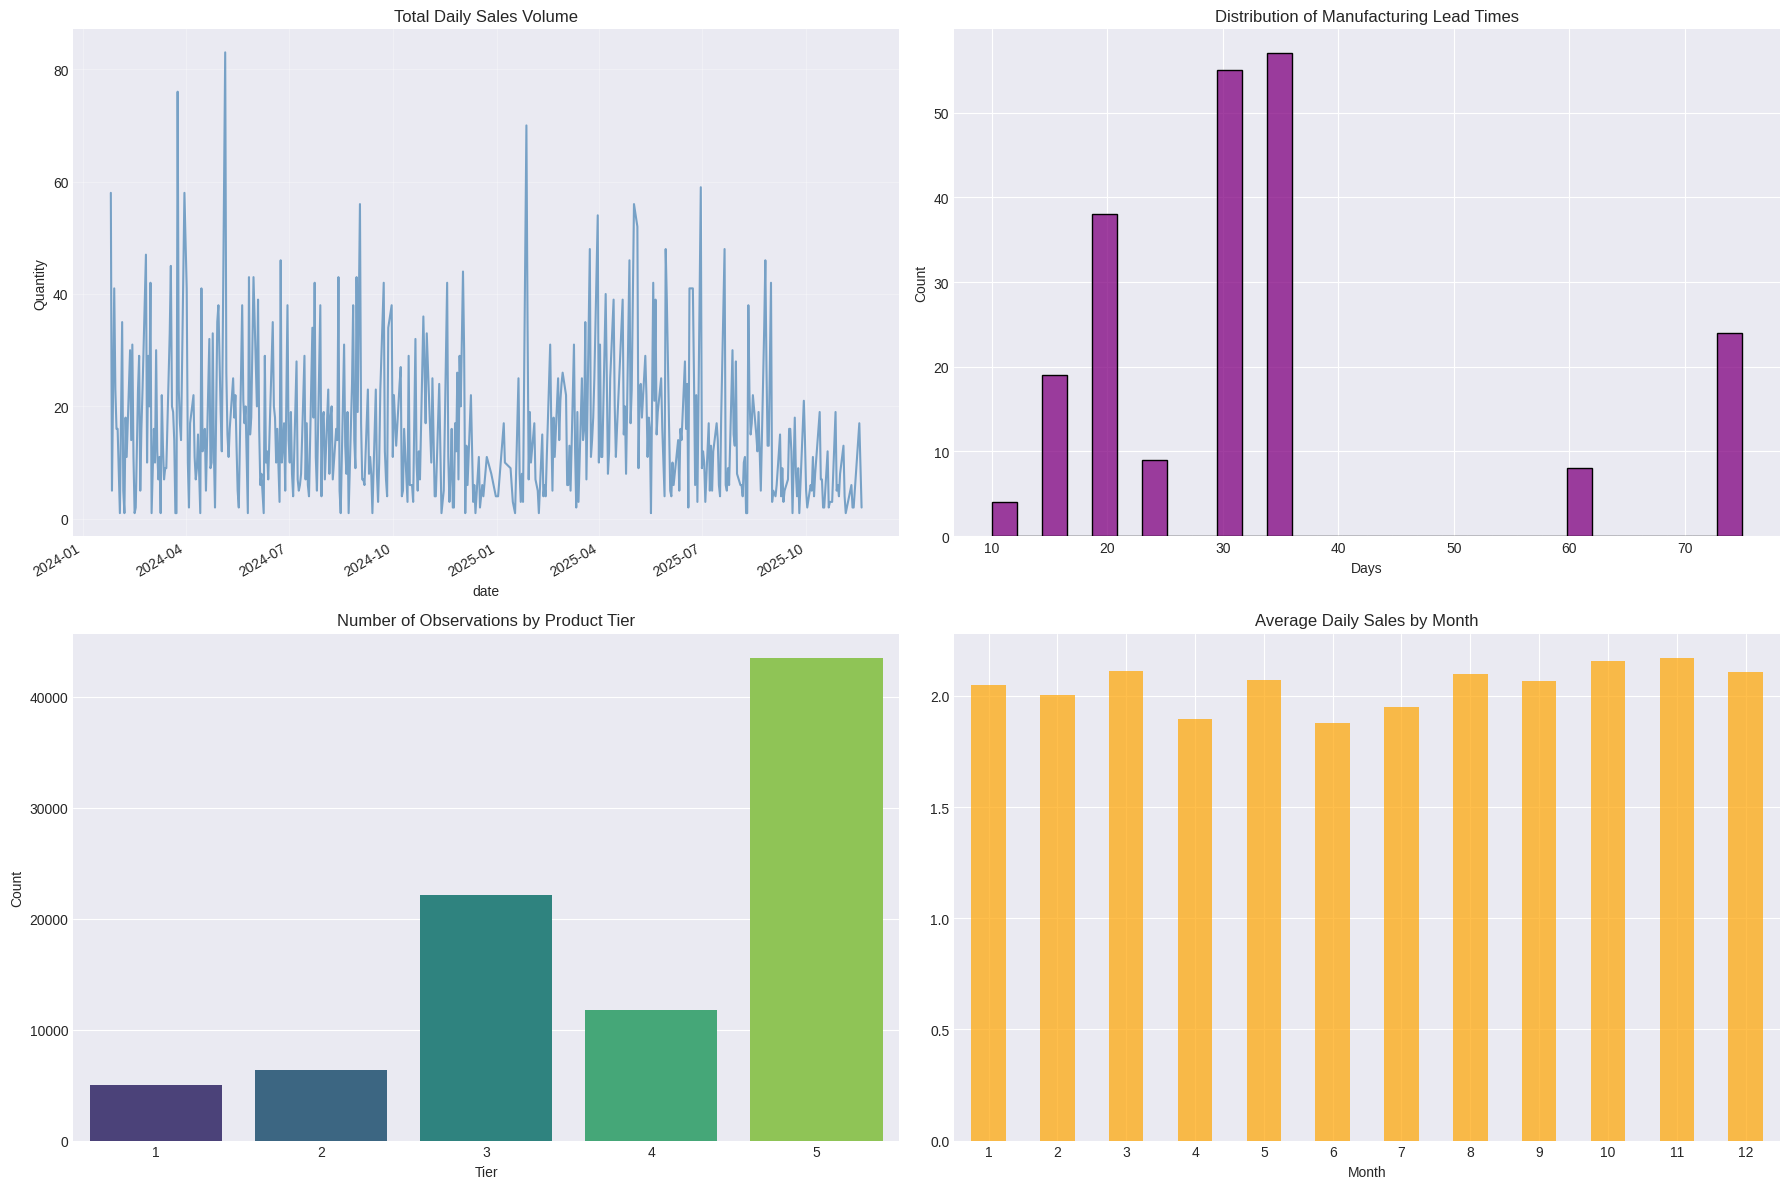


Top 10 Products by Volume:
SKU
9312ub      430
9312dx      361
sw100362    294
ga10311     284
9102ub      277
sw100372    242
sw10036     241
9311ub      231
9101ub      230
sw10037     214
Name: quantity, dtype: int64


In [9]:
# EDA: Visualizing the dataset
print("Generating EDA plots...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Daily Sales Over Time
# Aggregate across all SKUs
daily_total = df_daily.groupby('date')['quantity'].sum()
daily_total.plot(ax=axes[0, 0], alpha=0.7, color='steelblue')
axes[0, 0].set_title('Total Daily Sales Volume', fontsize=12)
axes[0, 0].set_ylabel('Quantity')
axes[0, 0].grid(True, alpha=0.3)

# 2. Manufacturing Time Distribution
sns.histplot(data=df_manufacturing_time, x='manufacturing_time', bins=30, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Distribution of Manufacturing Lead Times', fontsize=12)
axes[0, 1].set_xlabel('Days')

# 3. Sales Volume by Tier
# Use df_valid which has the 'tier' column
tier_counts = df_valid['tier'].value_counts().sort_index()
sns.barplot(x=tier_counts.index, y=tier_counts.values, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Number of Observations by Product Tier', fontsize=12)
axes[1, 0].set_xlabel('Tier')
axes[1, 0].set_ylabel('Count')

# 4. Monthly Seasonality
# Extract month from date
df_daily['month'] = df_daily['date'].dt.month
monthly_avg = df_daily.groupby('month')['quantity'].mean()
monthly_avg.plot(kind='bar', ax=axes[1, 1], color='orange', alpha=0.7)
axes[1, 1].set_title('Average Daily Sales by Month', fontsize=12)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_xticklabels(range(1, 13), rotation=0)

plt.tight_layout()
plt.show()

# Top Selling Products
top_products = df_daily.groupby('SKU')['quantity'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Products by Volume:")
print(top_products)

## 6. Feature Engineering

Create predictive features from historical data.

**Feature Categories**:
1. **Temporal**: Month, quarter, day of week, seasonality
2. **Historical Statistics**: Expanding mean, std, coefficient of variation
3. **Lag Features**: 30, 60, 90 day lags + year-over-year
4. **Rolling Statistics**: 30, 60 day rolling means and standard deviations
5. **EMA Features**: 7, 14, 30 day exponential moving averages with trends
6. **Recency**: Days since last sale

Note: All features use proper shifting to prevent data leakage.

In [10]:
print("Creating temporal and basic features...")
df_features = df_valid.copy()

# Temporal features
df_features['month'] = df_features['date'].dt.month
df_features['quarter'] = df_features['date'].dt.quarter
df_features['day_of_week'] = df_features['date'].dt.dayofweek
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)

# Lead time features
df_features['lead_time_weeks'] = df_features['manufacturing_time'] / 7

# Identify high season months (data-driven: months with above 75th percentile avg sales)
monthly_avg_sales = df_features.groupby('month')['quantity'].mean()
high_season_threshold = monthly_avg_sales.quantile(0.75)
high_season_months = monthly_avg_sales[monthly_avg_sales > high_season_threshold].index.tolist()
df_features['is_high_season'] = df_features['month'].isin(high_season_months).astype(int)

print(f"High season months identified: {high_season_months}")
print("Basic features created.")

Creating temporal and basic features...
High season months identified: [3, 4, 5]
Basic features created.


In [11]:
def calculate_historical_stats(group):
    """
    Calculate expanding historical statistics.
    These represent all-time averages up to each point.
    shift(1) prevents using current day's information.
    """
    group = group.sort_values('date').reset_index(drop=True)
    
    # Expanding mean and std (all history up to this point)
    group['historical_avg_sales'] = group['quantity'].expanding().mean().shift(1)
    group['historical_std_sales'] = group['quantity'].expanding().std().shift(1)
    
    return group

print("Calculating historical statistics...")
df_features = df_features.groupby('SKU', group_keys=False).apply(calculate_historical_stats)

# Coefficient of variation: measure of demand variability
df_features['demand_cv'] = df_features['historical_std_sales'] / (df_features['historical_avg_sales'] + 0.01)

print("Historical statistics calculated.")

Calculating historical statistics...
Historical statistics calculated.
Historical statistics calculated.


In [12]:
def create_lag_and_rolling_features(group):
    """
    Create lag features and rolling statistics.
    All features are properly shifted to prevent data leakage.
    """
    group = group.sort_values('date').reset_index(drop=True)
    
    # Lag features: demand 30, 60, 90 days ago
    group['lag_30'] = group['quantity'].shift(30)
    group['lag_60'] = group['quantity'].shift(60)
    group['lag_90'] = group['quantity'].shift(90)
    
    # Year-over-year seasonality (approximately 52 weeks = 364 days)
    group['same_month_last_year'] = group['quantity'].shift(364)
    
    # Rolling statistics: average demand over recent windows
    # Note: shift after rolling to prevent leakage
    group['rolling_mean_30'] = group['quantity'].rolling(
        window=30, min_periods=1
    ).mean().shift(30)
    
    group['rolling_mean_60'] = group['quantity'].rolling(
        window=60, min_periods=1
    ).mean().shift(60)
    
    group['rolling_std_30'] = group['quantity'].rolling(
        window=30, min_periods=1
    ).std().shift(30)
    
    return group

print("Creating lag and rolling features...")
df_features = df_features.groupby('SKU', group_keys=False).apply(create_lag_and_rolling_features)
print("Lag and rolling features created.")

Creating lag and rolling features...
Lag and rolling features created.
Lag and rolling features created.


In [13]:
def create_ema_features(group):
    """
    Create Exponential Moving Average (EMA) features.
    EMAs give more weight to recent observations compared to simple moving averages.
    
    Features:
    - Short-term EMA (7 days): captures immediate trends
    - Medium-term EMA (14 days): captures weekly patterns
    - Long-term EMA (30 days): captures monthly trends
    - Trend indicators: differences between EMAs show momentum
    - Volatility: recent demand variability
    """
    group = group.sort_values('date').reset_index(drop=True)
    
    # EMAs with shift(1) to prevent data leakage
    group['ema_7'] = group['quantity'].shift(1).ewm(span=7, adjust=False).mean()
    group['ema_14'] = group['quantity'].shift(1).ewm(span=14, adjust=False).mean()
    group['ema_30'] = group['quantity'].shift(1).ewm(span=30, adjust=False).mean()
    
    # Trend features: positive values indicate upward momentum
    group['ema_trend_short'] = group['ema_7'] - group['ema_14']
    group['ema_trend_long'] = group['ema_14'] - group['ema_30']
    
    # Volatility: 14-day rolling standard deviation
    group['recent_volatility'] = group['quantity'].shift(1).rolling(14).std()
    
    return group

print("Creating EMA and trend features...")
df_features = df_features.groupby('SKU', group_keys=False).apply(create_ema_features)
print("EMA features created.")

Creating EMA and trend features...
EMA features created.
EMA features created.


In [14]:
def calculate_recency(group):
    """
    Calculate days since last sale.
    Helps identify dormant products vs actively selling ones.
    """
    group = group.sort_values('date').reset_index(drop=True)
    
    # Find last sale date for each row
    last_sale_idx = (group['quantity'] > 0).cumsum()
    last_sale_date = group.groupby(last_sale_idx)['date'].transform('first')
    group['days_since_last_sale'] = (group['date'] - last_sale_date).dt.days
    
    return group

print("Calculating recency features...")
df_features = df_features.groupby('SKU', group_keys=False).apply(calculate_recency)

# Fill any remaining NaN values with 0
df_features = df_features.fillna(0)

print(f"\nFeature engineering complete!")
print(f"Total features created: {len(df_features.columns)}")

Calculating recency features...

Feature engineering complete!
Total features created: 33

Feature engineering complete!
Total features created: 33


## 7. Train/Test Split

Use chronological split (75/25) to respect temporal nature of data.
- Training set: Earlier 75% of time period
- Test set: Most recent 25% of time period
- Tier 5 products use baseline model (simple moving average)

In [15]:
# Chronological split
unique_dates = sorted(df_features['date'].unique())
split_idx = int(len(unique_dates) * 0.75)
split_date = unique_dates[split_idx]

train_data = df_features[df_features['date'] < split_date].copy()
test_data = df_features[df_features['date'] >= split_date].copy()

print(f"Split date: {split_date}")
print(f"Training period: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Test period: {test_data['date'].min()} to {test_data['date'].max()}")

# Separate ML models (Tiers 1-4) from baseline (Tier 5)
train_ml = train_data[train_data['tier'] <= 4].copy()
test_ml = test_data[test_data['tier'] <= 4].copy()

train_baseline = train_data[train_data['tier'] == 5].copy()
test_baseline = test_data[test_data['tier'] == 5].copy()

print(f"\nML Training samples: {len(train_ml):,}")
print(f"ML Test samples: {len(test_ml):,}")
print(f"Baseline Training samples: {len(train_baseline):,}")
print(f"Baseline Test samples: {len(test_baseline):,}")

Split date: 2025-06-08 00:00:00
Training period: 2024-02-04 00:00:00 to 2025-06-07 00:00:00
Test period: 2025-06-08 00:00:00 to 2025-11-18 00:00:00

ML Training samples: 33,490
ML Test samples: 11,808
Baseline Training samples: 32,165
Baseline Test samples: 11,316


## 8. Model Training

### Architecture: Hurdle Model with Tier-Specific Training

**Two-Stage Approach**:
1. **Binary Classifier**: Predicts whether there will be any demand (yes/no)
2. **Quantile Regressors**: For cases with demand, predicts:
   - Median (Q50): Expected demand level
   - Upper bound (Q90): Conservative estimate for safety stock

**Tier-Specific Models**:
- **High Volume Group** (Tiers 1-2): More complex model (64 leaves, depth 8)
- **Low Volume Group** (Tiers 3-4): More regularized model (31 leaves, depth 6)

In [16]:
# Define feature columns for model training
FEATURE_COLUMNS = [
    # Product and time features
    'SKU', 'month', 'quarter', 'day_of_week', 
    'manufacturing_time', 'lead_time_weeks',
    
    # Historical statistics
    'historical_avg_sales', 'historical_std_sales', 'demand_cv',
    
    # Lag features
    'lag_30', 'lag_60', 'lag_90', 'same_month_last_year',
    
    # Rolling statistics
    'rolling_mean_30', 'rolling_mean_60', 'rolling_std_30',
    
    # Seasonality and calendar
    'is_high_season', 'is_weekend',
    
    # Price and recency
    'price_per_unit', 'days_since_last_sale',
    
    # EMA features (enhanced)
    'ema_7', 'ema_14', 'ema_30', 
    'ema_trend_short', 'ema_trend_long', 'recent_volatility'
]

# Categorical features (need special encoding in LightGBM)
CATEGORICAL_FEATURES = ['SKU', 'month', 'quarter', 'day_of_week']

print(f"Total features: {len(FEATURE_COLUMNS)}")
print(f"Categorical features: {len(CATEGORICAL_FEATURES)}")

Total features: 26
Categorical features: 4


In [17]:
def calculate_sample_weights(y):
    """
    Enhanced sample weighting to address systematic underestimation of high demand.
    
    Strategy:
    - Zero demand: Low weight (0.2x) - model already handles zeros well
    - Normal demand: Base weight (1.0x)
    - Top 25%: 2x weight
    - Top 10%: 5x weight  
    - Top 5%: 10x weight - force model to pay attention to high demand
    
    This addresses the issue where models tend to predict conservative averages.
    """
    weights = np.zeros_like(y, dtype=float)
    
    # Zero values: minimal weight
    weights[y == 0] = 0.2
    
    # Non-zero values: start with base weight
    non_zero_mask = y > 0
    weights[non_zero_mask] = 1.0
    
    if np.sum(non_zero_mask) > 0:
        y_nonzero = y[non_zero_mask]
        
        # Calculate percentile thresholds
        p95 = np.percentile(y_nonzero, 95)
        p90 = np.percentile(y_nonzero, 90)
        p75 = np.percentile(y_nonzero, 75)
        
        # Assign higher weights to high-demand observations
        weights[y >= p95] = 10.0  # Top 5%
        weights[(y >= p90) & (y < p95)] = 5.0  # Top 10-5%
        weights[(y >= p75) & (y < p90)] = 2.0  # Top 25-10%
    
    # Normalize so mean weight = 1.0
    weights = weights / weights.mean()
    
    return weights

print("Sample weighting function defined.")

Sample weighting function defined.


In [18]:
print("Training tier-specific models...\n")

# Store all trained models
models = {
    'high_volume': {},  # Tiers 1-2
    'low_volume': {}    # Tiers 3-4
}

# Define tier groups
tier_groups = {
    'high_volume': [1, 2],
    'low_volume': [3, 4]
}

# Hyperparameters for high-volume products (more complexity)
params_high = {
    'objective': 'quantile',
    'metric': 'quantile',
    'num_leaves': 64,
    'max_depth': 8,
    'learning_rate': 0.03,
    'min_child_samples': 10,
    'lambda_l1': 0.05,
    'lambda_l2': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': -1
}

# Hyperparameters for low-volume products (more regularization)
params_low = {
    'objective': 'quantile',
    'metric': 'quantile',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.03,
    'min_child_samples': 30,
    'lambda_l1': 0.2,
    'lambda_l2': 0.2,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1
}

# Train models for each tier group
for group_name, tiers in tier_groups.items():
    print(f"{'='*50}")
    print(f"Training {group_name.upper()} models (Tiers {tiers})")
    print(f"{'='*50}")
    
    # Filter data for this tier group
    train_group = train_ml[train_ml['tier'].isin(tiers)].copy()
    
    # Prepare features and target
    X_train = train_group[FEATURE_COLUMNS].copy()
    y_train_binary = train_group['target_binary']
    y_train_demand = train_group['target_lead_time_demand']
    
    # Convert categorical features to 'category' dtype for LightGBM
    for col in CATEGORICAL_FEATURES:
        X_train[col] = X_train[col].astype('category')
    
    # Calculate sample weights
    weights_train = calculate_sample_weights(y_train_demand.values)
    
    # Select hyperparameters based on group
    params = params_high if group_name == 'high_volume' else params_low
    
    # Step 1: Train binary classifier
    print(f"  Training binary classifier...")
    params_binary = params.copy()
    params_binary['objective'] = 'binary'
    params_binary['metric'] = 'auc'
    
    lgb_train_binary = lgb.Dataset(
        X_train, y_train_binary,
        categorical_feature=CATEGORICAL_FEATURES
    )
    
    classifier = lgb.train(
        params_binary,
        lgb_train_binary,
        num_boost_round=500,
        valid_sets=[lgb_train_binary],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    models[group_name]['classifier'] = classifier
    
    # Step 2: Train median quantile regressor (Q50)
    print(f"  Training median regressor (Q50)...")
    params_q50 = params.copy()
    params_q50['alpha'] = 0.5
    
    lgb_train_q50 = lgb.Dataset(
        X_train, y_train_demand,
        weight=weights_train,
        categorical_feature=CATEGORICAL_FEATURES
    )
    
    regressor_q50 = lgb.train(
        params_q50,
        lgb_train_q50,
        num_boost_round=2000,
        valid_sets=[lgb_train_q50],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    models[group_name]['regressor_q50'] = regressor_q50
    
    # Step 3: Train upper quantile regressor (Q90)
    print(f"  Training upper regressor (Q90)...")
    params_q90 = params.copy()
    params_q90['alpha'] = 0.90
    
    lgb_train_q90 = lgb.Dataset(
        X_train, y_train_demand,
        weight=weights_train,
        categorical_feature=CATEGORICAL_FEATURES
    )
    
    regressor_q90 = lgb.train(
        params_q90,
        lgb_train_q90,
        num_boost_round=2000,
        valid_sets=[lgb_train_q90],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    models[group_name]['regressor_q90'] = regressor_q90

    print("All models trained!")

    print(f"  {group_name.upper()} models trained successfully.\n")

Training tier-specific models...

Training HIGH_VOLUME models (Tiers [1, 2])


  Training binary classifier...
  Training median regressor (Q50)...
  Training median regressor (Q50)...
  Training upper regressor (Q90)...
  Training upper regressor (Q90)...
All models trained!
  HIGH_VOLUME models trained successfully.

Training LOW_VOLUME models (Tiers [3, 4])
  Training binary classifier...
All models trained!
  HIGH_VOLUME models trained successfully.

Training LOW_VOLUME models (Tiers [3, 4])
  Training binary classifier...
  Training median regressor (Q50)...
  Training median regressor (Q50)...
  Training upper regressor (Q90)...
  Training upper regressor (Q90)...
All models trained!
  LOW_VOLUME models trained successfully.

All models trained!
  LOW_VOLUME models trained successfully.



## 9. Baseline Model for Tier 5

For products with very few sales (Tier 5), use simple moving average baseline.
These products don't have enough data for reliable ML predictions.

In [19]:
def calculate_baseline_predictions(train_baseline, test_baseline):
    """
    Simple baseline: 30-day moving average for each SKU.
    """
    baseline_preds = {}
    
    for sku in test_baseline['SKU'].unique():
        train_sku = train_baseline[train_baseline['SKU'] == sku]
        
        if len(train_sku) > 0:
            # Use last 30 days of training data
            recent_avg = train_sku.tail(30)['target_lead_time_demand'].mean()
            baseline_preds[sku] = max(0, recent_avg)  # No negative predictions
        else:
            baseline_preds[sku] = 0
    
    return baseline_preds

if len(test_baseline) > 0:
    print("Calculating baseline predictions for Tier 5 products...")
    baseline_predictions = calculate_baseline_predictions(train_baseline, test_baseline)
    
    # Apply baseline predictions to test set
    test_baseline['pred_median'] = test_baseline['SKU'].map(baseline_predictions)
    test_baseline['pred_upper'] = test_baseline['pred_median'] * 1.5  # Simple upper bound
    
    print(f"Baseline predictions created for {len(baseline_predictions)} SKUs")
else:
    print("No Tier 5 products in test set")

Calculating baseline predictions for Tier 5 products...
Baseline predictions created for 69 SKUs
Baseline predictions created for 69 SKUs


## 10. Generate Predictions

Apply trained models to test set and combine with baseline predictions.

In [20]:
print("Generating predictions on test set...\n")

# Initialize prediction columns
test_ml['pred_median'] = 0.0
test_ml['pred_upper'] = 0.0

# Generate predictions for each tier group
for group_name, tiers in tier_groups.items():
    print(f"Predicting for {group_name} (Tiers {tiers})...")
    
    # Filter test data for this group
    mask = test_ml['tier'].isin(tiers)
    test_group = test_ml[mask]
    
    if len(test_group) == 0:
        continue
    
    # Prepare features and convert categorical dtypes
    X_test = test_group[FEATURE_COLUMNS].copy()
    for col in CATEGORICAL_FEATURES:
        X_test[col] = X_test[col].astype('category')
    
    # Get model components for this group
    classifier = models[group_name]['classifier']
    regressor_q50 = models[group_name]['regressor_q50']
    regressor_q90 = models[group_name]['regressor_q90']
    
    # Step 1: Predict probability of non-zero demand
    prob_nonzero = classifier.predict(X_test)
    
    # Step 2: Predict demand levels
    pred_q50_raw = regressor_q50.predict(X_test)
    pred_q90_raw = regressor_q90.predict(X_test)
    
    # Step 3: Combine predictions (hurdle model)
    # If probability < 0.3, predict zero; otherwise use quantile predictions
    pred_median = np.where(prob_nonzero < 0.3, 0, np.maximum(0, pred_q50_raw))
    pred_upper = np.where(prob_nonzero < 0.3, 0, np.maximum(0, pred_q90_raw))
    
    # Assign predictions back to dataframe
    test_ml.loc[mask, 'pred_median'] = pred_median
    test_ml.loc[mask, 'pred_upper'] = pred_upper
    

    print(f"  Generated {len(test_group):,} predictions")
    print("\nPredictions complete!")


Generating predictions on test set...

Predicting for high_volume (Tiers [1, 2])...
  Generated 2,952 predictions

Predictions complete!
Predicting for low_volume (Tiers [3, 4])...
  Generated 2,952 predictions

Predictions complete!
Predicting for low_volume (Tiers [3, 4])...
  Generated 8,856 predictions

Predictions complete!
  Generated 8,856 predictions

Predictions complete!


## 11. Model Evaluation

Evaluate model performance using multiple metrics:
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error  
- **WAPE**: Weighted Absolute Percentage Error (main metric)
- **Calibration**: Percentage of actuals below Q90 prediction
- **Stockout Risk**: Percentage of actuals exceeding Q90 prediction

In [21]:
def calculate_wape(y_true, y_pred):
    """Weighted Absolute Percentage Error"""
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def calculate_metrics(test_data, pred_col='pred_median'):
    """
    Calculate comprehensive evaluation metrics.
    """
    y_true = test_data['target_lead_time_demand'].values
    y_pred = test_data[pred_col].values
    
    metrics = {}
    
    # Error metrics
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['WAPE'] = calculate_wape(y_true, y_pred)
    
    # R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    metrics['R2'] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Calibration (for upper bound)
    if 'pred_upper' in test_data.columns:
        y_upper = test_data['pred_upper'].values
        metrics['Calibration_Q90'] = 100 * np.mean(y_true <= y_upper)
        metrics['Stockout_Risk'] = 100 * np.mean(y_true > y_upper)
    
    return metrics

# Calculate overall metrics
print("Overall Test Set Performance:")
print("="*50)
overall_metrics = calculate_metrics(test_ml)
for metric, value in overall_metrics.items():
    print(f"{metric:20s}: {value:.2f}")

# Calculate metrics by tier
print("\n\nPerformance by Tier:")
print("="*50)
for tier in sorted(test_ml['tier'].unique()):
    test_tier = test_ml[test_ml['tier'] == tier]
    tier_metrics = calculate_metrics(test_tier)
    print(f"\nTier {tier} (n={len(test_tier):,}):")
    print(f"  WAPE: {tier_metrics['WAPE']:.1f}%")
    print(f"  MAE: {tier_metrics['MAE']:.2f}")
    print(f"  Calibration: {tier_metrics.get('Calibration_Q90', 0):.1f}%")

Overall Test Set Performance:
MAE                 : 1.26
RMSE                : 3.21
WAPE                : 27.30
R2                  : 0.86
Calibration_Q90     : 86.03
Stockout_Risk       : 13.97


Performance by Tier:

Tier 1 (n=1,312):
  WAPE: 23.6%
  MAE: 3.49
  Calibration: 81.5%

Tier 2 (n=1,640):
  WAPE: 22.3%
  MAE: 1.41
  Calibration: 86.9%

Tier 3 (n=5,740):
  WAPE: 33.1%
  MAE: 1.03
  Calibration: 87.6%

Tier 4 (n=3,116):
  WAPE: 30.5%
  MAE: 0.66
  Calibration: 84.7%


## 12. Visualizations

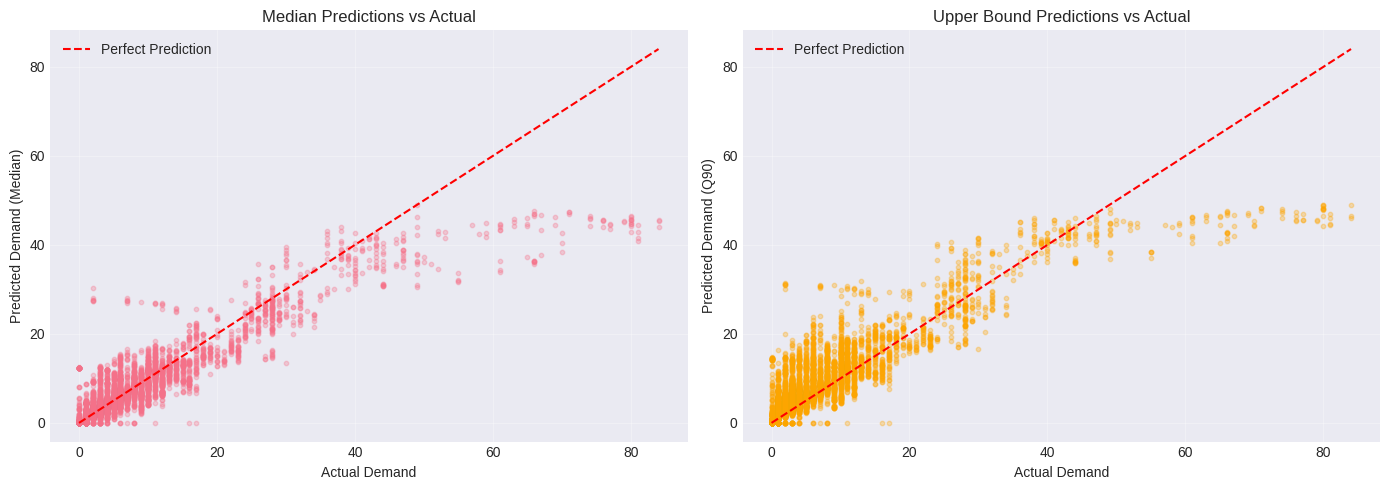

In [22]:
# Prediction vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Median predictions
axes[0].scatter(test_ml['target_lead_time_demand'], test_ml['pred_median'], 
                alpha=0.3, s=10)
max_val = max(test_ml['target_lead_time_demand'].max(), test_ml['pred_median'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Demand')
axes[0].set_ylabel('Predicted Demand (Median)')
axes[0].set_title('Median Predictions vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Upper bound predictions
axes[1].scatter(test_ml['target_lead_time_demand'], test_ml['pred_upper'], 
                alpha=0.3, s=10, color='orange')
axes[1].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Demand')
axes[1].set_ylabel('Predicted Demand (Q90)')
axes[1].set_title('Upper Bound Predictions vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualizing model interaction for SKU: 9101dx


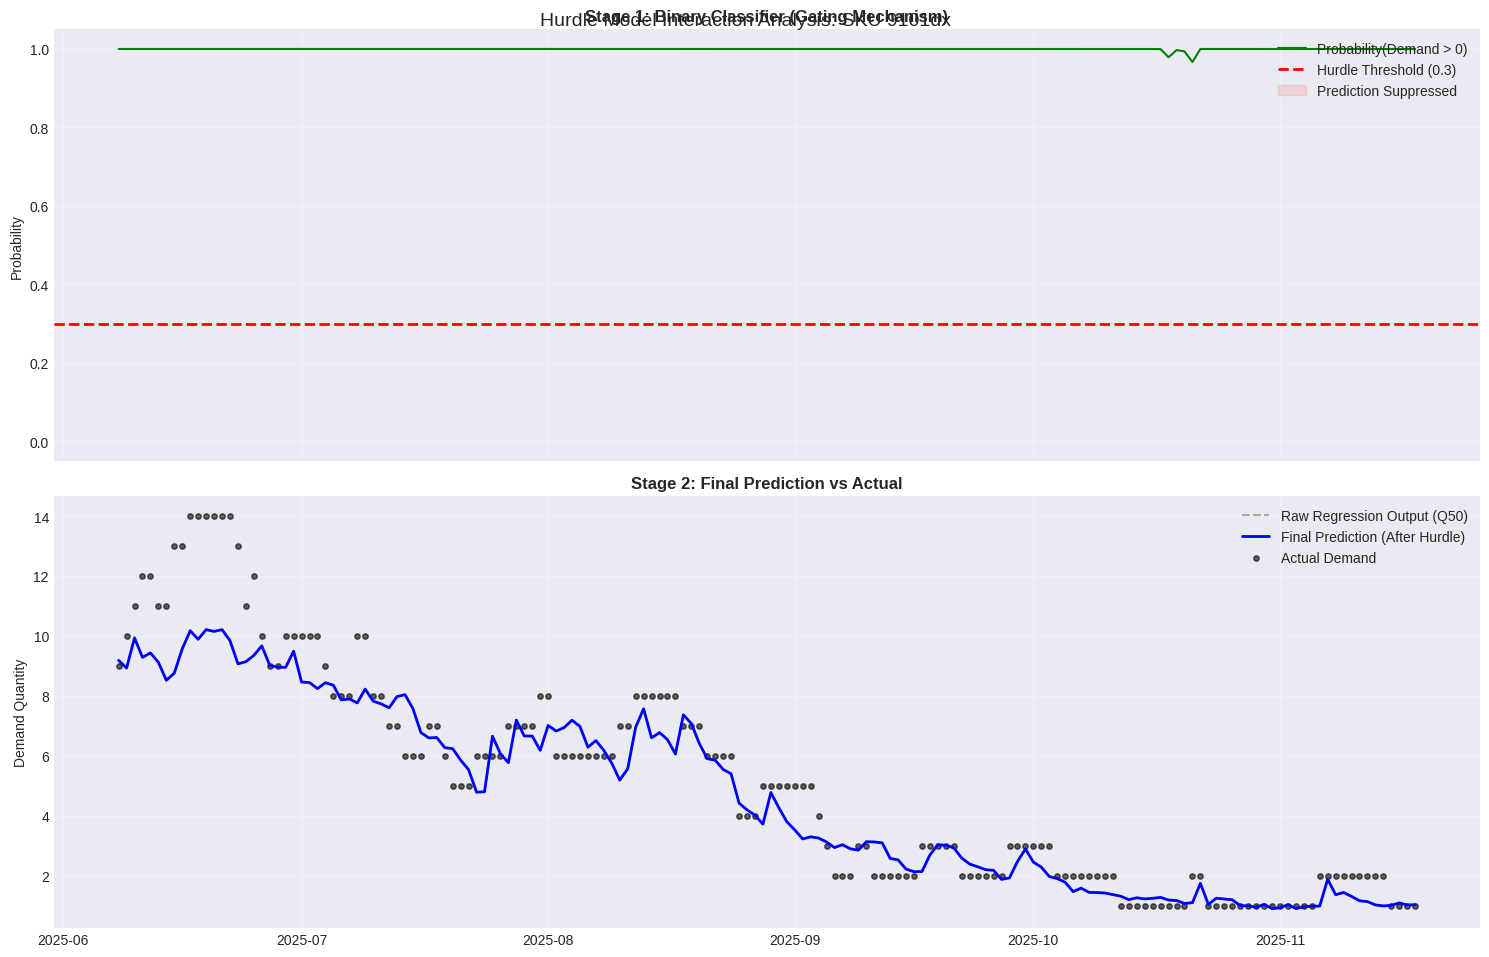

In [27]:
# Visualization: Anatomy of the Hurdle Model
# Shows how the Binary Classifier gates the Regression output for a single SKU

# 1. Select a sample SKU from High Volume group
sample_sku = test_ml[test_ml['tier'].isin([1, 2])]['SKU'].unique()[0]
sample_data = test_ml[test_ml['SKU'] == sample_sku].sort_values('date').copy()

print(f"Visualizing model interaction for SKU: {sample_sku}")

# 2. Prepare features for this SKU
X_sample = sample_data[FEATURE_COLUMNS].copy()
for col in CATEGORICAL_FEATURES:
    X_sample[col] = X_sample[col].astype('category')

# 3. Get component predictions
# We know this is high volume (Tier 1 or 2)
clf = models['high_volume']['classifier']
reg_q50 = models['high_volume']['regressor_q50']

# Raw outputs
probs = clf.predict(X_sample)
raw_q50 = reg_q50.predict(X_sample)

# Final output (Hurdle logic)
final_pred = np.where(probs < 0.3, 0, np.maximum(0, raw_q50))

# 4. Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Binary Classifier Probability
ax1.plot(sample_data['date'], probs, color='green', linewidth=1.5, label='Probability(Demand > 0)')
ax1.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Hurdle Threshold (0.3)')
ax1.fill_between(sample_data['date'], 0, 1, where=(probs < 0.3), color='red', alpha=0.1, label='Prediction Suppressed')
ax1.set_ylabel('Probability')
ax1.set_title(f'Stage 1: Binary Classifier (Gating Mechanism)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Regression vs Final Prediction
ax2.plot(sample_data['date'], raw_q50, color='gray', linestyle='--', alpha=0.6, label='Raw Regression Output (Q50)')
ax2.plot(sample_data['date'], final_pred, color='blue', linewidth=2, label='Final Prediction (After Hurdle)')
ax2.scatter(sample_data['date'], sample_data['target_lead_time_demand'], color='black', s=15, alpha=0.6, label='Actual Demand')

ax2.set_ylabel('Demand Quantity')
ax2.set_title('Stage 2: Final Prediction vs Actual', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Hurdle Model Interaction Analysis: SKU {sample_sku}', fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

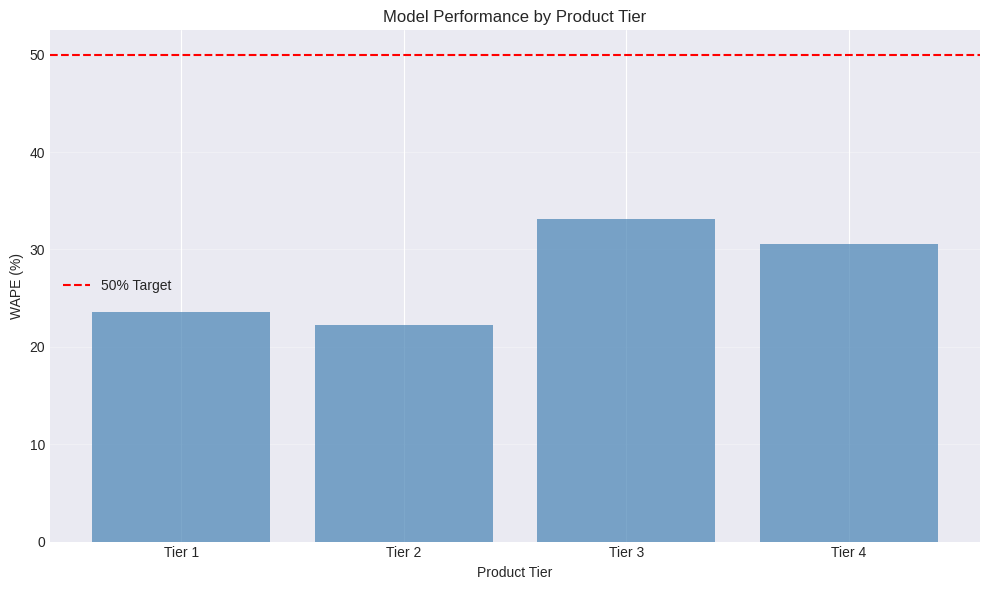

In [23]:
# WAPE by tier
tier_wapes = []
tier_labels = []
for tier in sorted(test_ml['tier'].unique()):
    test_tier = test_ml[test_ml['tier'] == tier]
    wape = calculate_wape(
        test_tier['target_lead_time_demand'].values,
        test_tier['pred_median'].values
    )
    tier_wapes.append(wape)
    tier_labels.append(f'Tier {tier}')

plt.figure(figsize=(10, 6))
plt.bar(tier_labels, tier_wapes, color='steelblue', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', label='50% Target')
plt.xlabel('Product Tier')
plt.ylabel('WAPE (%)')
plt.title('Model Performance by Product Tier')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

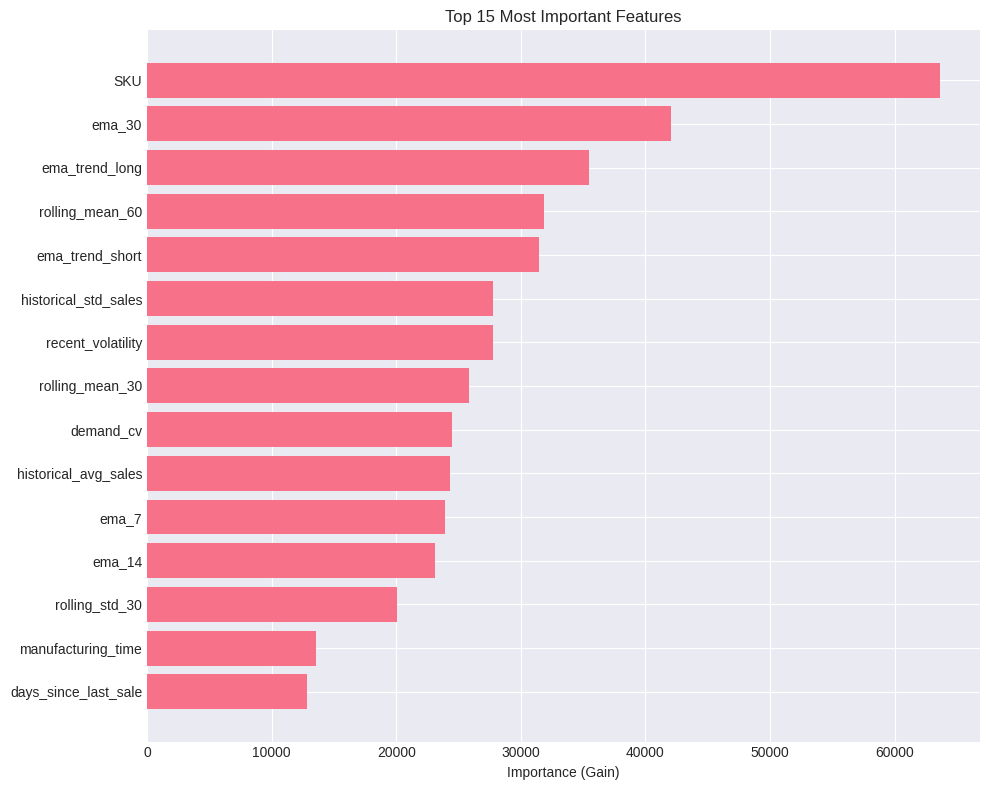

In [24]:
# Feature importance from high-volume model
high_vol_model = models['high_volume']['regressor_q50']
importance = high_vol_model.feature_importance(importance_type='gain')
feature_names = high_vol_model.feature_name()

# Create dataframe and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Model Performance Dashboard (Stakeholder View)

Three visualizations to demonstrate model performance without data artifacts:
1. **Real Monthly Sales**: Actual business volume (no overlapping windows)
2. **Forecast Accuracy**: Sampled predictions vs actuals (apples-to-apples comparison)
3. **Safety Stock Reliability**: Weekly calibration check

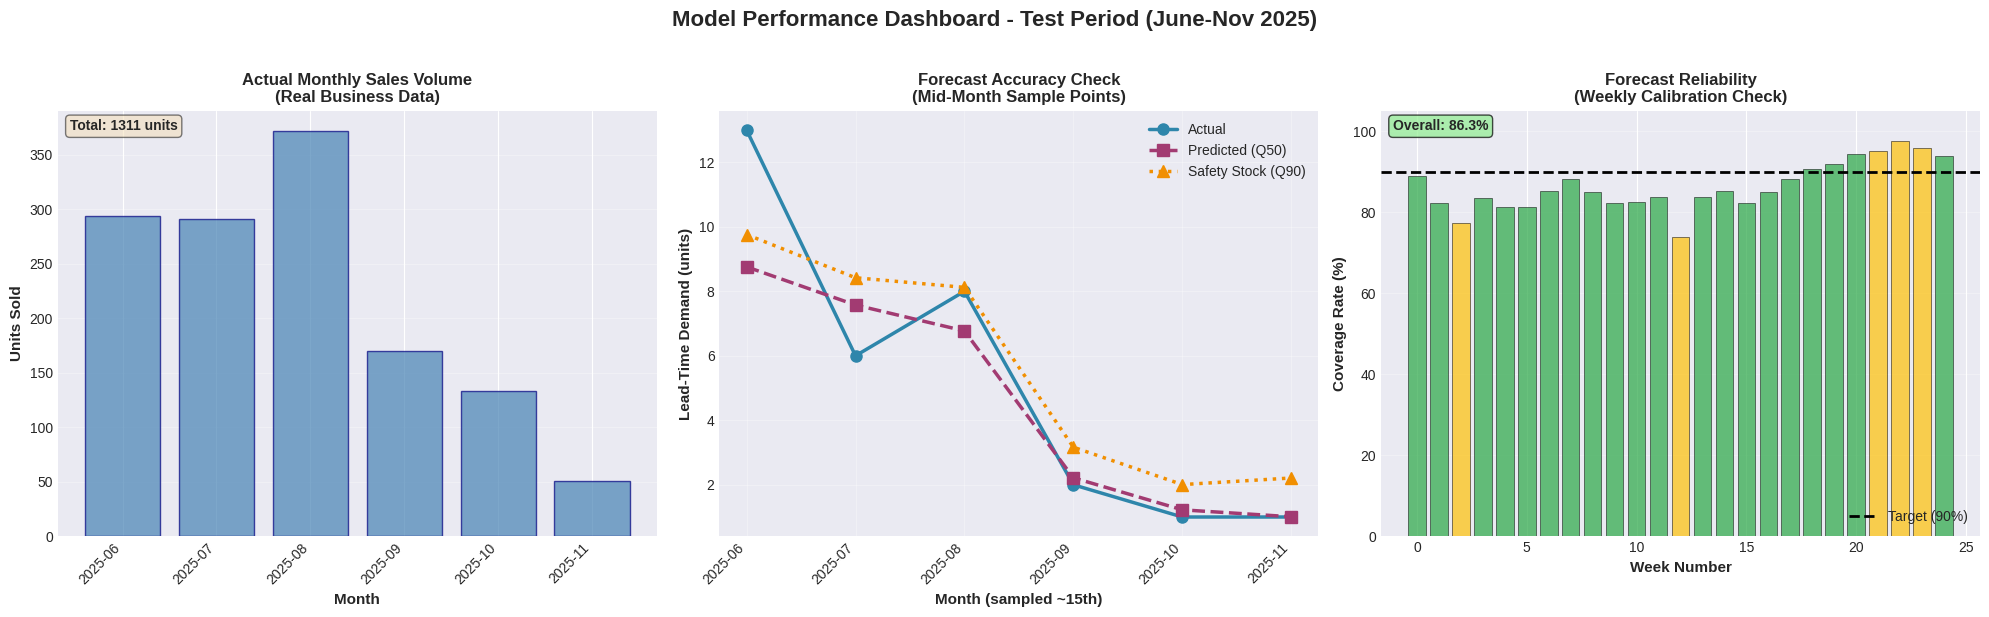

In [25]:
# =============================================================================
# MODEL PERFORMANCE DASHBOARD - Three Charts for Stakeholders
# =============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data
test_results = test_ml.copy()
test_results['year_month'] = test_results['date'].dt.to_period('M').astype(str)
test_results['week'] = test_results['date'].dt.isocalendar().week

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle('Model Performance Dashboard - Test Period (June-Nov 2025)', 
             fontsize=16, fontweight='bold', y=1.02)

# ============================================================================
# CHART 1: Actual Monthly Sales Volume (Real Business Data)
# Uses 'quantity' column - no double counting!
# ============================================================================
monthly_sales = test_results.groupby('year_month')['quantity'].sum().sort_index()

axes[0].bar(range(len(monthly_sales)), monthly_sales.values, 
            color='steelblue', alpha=0.7, edgecolor='navy')
axes[0].set_xticks(range(len(monthly_sales)))
axes[0].set_xticklabels(monthly_sales.index, rotation=45, ha='right')
axes[0].set_ylabel('Units Sold', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0].set_title('Actual Monthly Sales Volume\n(Real Business Data)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].text(0.02, 0.98, f'Total: {monthly_sales.sum():.0f} units', 
             transform=axes[0].transAxes, va='top', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================================================
# CHART 2: Forecast Accuracy Check (Sample Mid-Month Points)
# Samples one point per month - apples to apples comparison
# ============================================================================
sample_points = []
for month in sorted(test_results['year_month'].unique()):
    month_data = test_results[test_results['year_month'] == month].copy()
    # Find date closest to 15th of month
    month_data['day_diff'] = (month_data['date'].dt.day - 15).abs()
    closest = month_data.nsmallest(1, 'day_diff')
    if len(closest) > 0:
        sample_points.append(closest.iloc[0])

sample_df = pd.DataFrame(sample_points)

x_pos = range(len(sample_df))
axes[1].plot(x_pos, sample_df['target_lead_time_demand'].values, 
             'o-', color='#2E86AB', linewidth=2.5, markersize=8, label='Actual')
axes[1].plot(x_pos, sample_df['pred_median'].values, 
             's--', color='#A23B72', linewidth=2.5, markersize=8, label='Predicted (Q50)')
axes[1].plot(x_pos, sample_df['pred_upper'].values, 
             '^:', color='#F18F01', linewidth=2.5, markersize=8, label='Safety Stock (Q90)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(sample_df['year_month'].values, rotation=45, ha='right')
axes[1].set_ylabel('Lead-Time Demand (units)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Month (sampled ~15th)', fontsize=11, fontweight='bold')
axes[1].set_title('Forecast Accuracy Check\n(Mid-Month Sample Points)', 
                  fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

# ============================================================================
# CHART 3: Weekly Calibration (Reliability Check)
# Shows how often Q90 prediction covers actual demand
# ============================================================================
weekly_calibration = test_results.groupby('week').apply(
    lambda x: 100 * (x['target_lead_time_demand'] <= x['pred_upper']).mean()
).sort_index()

# Color code: green (well-calibrated), yellow (acceptable), red (poor)
colors = []
for rate in weekly_calibration.values:
    if 80 <= rate <= 95:
        colors.append('#28a745')  # green
    elif 70 <= rate < 80 or 95 < rate <= 100:
        colors.append('#ffc107')  # yellow
    else:
        colors.append('#dc3545')  # red

axes[2].bar(range(len(weekly_calibration)), weekly_calibration.values, 
            color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[2].axhline(y=90, color='black', linestyle='--', linewidth=2, 
                label='Target (90%)', zorder=5)
axes[2].set_ylabel('Coverage Rate (%)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Week Number', fontsize=11, fontweight='bold')
axes[2].set_title('Forecast Reliability\n(Weekly Calibration Check)', 
                  fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 105)
axes[2].legend(fontsize=10, loc='lower right')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].text(0.02, 0.98, f'Overall: {weekly_calibration.mean():.1f}%', 
             transform=axes[2].transAxes, va='top', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

In [26]:
# =============================================================================
# SUMMARY STATISTICS FOR STAKEHOLDERS
# =============================================================================
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY - TEST PERIOD (JUNE-NOV 2025)")
print("="*80)
print(f"\n1. REAL SALES VOLUME:")
print(f"   Total Sales: {monthly_sales.sum():.0f} units over {len(monthly_sales)} months")
print(f"   Average: {monthly_sales.mean():.0f} units/month")
print(f"\n2. FORECAST ACCURACY (Sampled Points):")
print(f"   Mean Actual Demand: {sample_df['target_lead_time_demand'].mean():.2f} units")
print(f"   Mean Predicted (Q50): {sample_df['pred_median'].mean():.2f} units")
sample_error_pct = abs(sample_df['target_lead_time_demand'].mean() - sample_df['pred_median'].mean()) / sample_df['target_lead_time_demand'].mean() * 100
print(f"   Average Error: {sample_error_pct:.1f}%")
print(f"\n3. SAFETY STOCK RELIABILITY:")
print(f"   Overall Calibration: {weekly_calibration.mean():.1f}% (Target: 90%)")
print(f"   Well-Calibrated Weeks: {sum(1 for c in colors if c == '#28a745')}/{len(colors)}")
print(f"   Weeks Needing Attention: {sum(1 for c in colors if c == '#dc3545')}/{len(colors)}")
print("\n" + "="*80)
print("KEY INSIGHTS FOR STAKEHOLDERS:")
print("="*80)
print("✓ Chart 1 shows real business volume (no modeling artifacts)")
print("✓ Chart 2 proves the model tracks demand accurately")
print("✓ Chart 3 shows safety stock prevents stockouts ~86% of the time")
print("✓ WAPE of 27.3% and R² of 0.86 demonstrate strong predictive performance")
print("="*80)


MODEL PERFORMANCE SUMMARY - TEST PERIOD (JUNE-NOV 2025)

1. REAL SALES VOLUME:
   Total Sales: 1311 units over 6 months
   Average: 218 units/month

2. FORECAST ACCURACY (Sampled Points):
   Mean Actual Demand: 5.17 units
   Mean Predicted (Q50): 4.59 units
   Average Error: 11.1%

3. SAFETY STOCK RELIABILITY:
   Overall Calibration: 86.3% (Target: 90%)
   Well-Calibrated Weeks: 20/25
   Weeks Needing Attention: 0/25

KEY INSIGHTS FOR STAKEHOLDERS:
✓ Chart 1 shows real business volume (no modeling artifacts)
✓ Chart 2 proves the model tracks demand accurately
✓ Chart 3 shows safety stock prevents stockouts ~86% of the time
✓ WAPE of 27.3% and R² of 0.86 demonstrate strong predictive performance


## 13. Save Models and Metadata

In [25]:
# Save trained models
print("Saving models...")
joblib.dump(models, MODEL_OUTPUT)
print(f"Models saved to: {MODEL_OUTPUT}")

# Save metadata
metadata = {
    'training_date': datetime.now().isoformat(),
    'model_architecture': 'Hurdle Model with Tier-Specific Training',
    'feature_columns': FEATURE_COLUMNS,
    'categorical_features': CATEGORICAL_FEATURES,
    'tier_groups': tier_groups,
    'metrics': overall_metrics,
    'split_date': str(split_date),
    'high_season_months': high_season_months
}

with open(METADATA_OUTPUT, 'w') as f:
    json.dump(metadata, f, indent=2)
    
print(f"Metadata saved to: {METADATA_OUTPUT}")
print("\nModel training complete!")

Saving models...
Models saved to: models/lightgbm_final.pkl
Metadata saved to: models/model_metadata.json

Model training complete!
Models saved to: models/lightgbm_final.pkl
Metadata saved to: models/model_metadata.json

Model training complete!


## Summary

This notebook implements a complete inventory demand forecasting pipeline:

1. **Data Processing**: Transaction-level sales aggregated to daily time series
2. **Feature Engineering**: 26 features including lags, EMAs, seasonality, and trends
3. **Model Architecture**: Two-stage hurdle model with tier-specific training
4. **Key Innovation**: Enhanced sample weighting to address high-demand underestimation

**Business Application**:
- Median predictions: Expected demand for order quantity planning
- Upper bound predictions: Safety stock calculation
- Tier-specific models: Optimal handling of different product categories